In [1]:
"""
===========================
Cross Subject SSVEP
===========================
This example shows how to perform a cross subject analysis on a SSVEP dataset.
We will compare two pipelines :
- Riemannian Geometry
- CCA
We will use the SSVEP paradigm, which uses the AUC as metric.
"""
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>
#
# License: BSD (3-clause)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances

from moabb.evaluations import CrossSubjectEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.datasets import SSVEPExo
from moabb.pipelines import SSVEP_CCA, ExtendedSSVEPSignal
import moabb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
moabb.set_log_level('info')

In [2]:
###############################################################################
# Loading dataset
# ---------------
#
# We will load the data from the first 2 subjects of the SSVEP_Exo dataset
# and compare two algorithms on this set. One of the algorithm could only
# process class associated with a stimulation frequency, we will thus drop
# the resting class. As the resting class is the last defined class, picking
# the first three classes (out of four) allows to focus only on the stimulation
# frequency.

n_subject = 2
for i in range(n_subject):
    SSVEPExo()._get_single_subject_data(i + 1)
dataset = SSVEPExo()
dataset.subject_list = dataset.subject_list[:n_subject]
interval = dataset.interval
paradigm = SSVEP(fmin=10, fmax=25, n_classes=3)
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=3)

# Classes are defined by the frequency of the stimulation, here we use
# the first two frequencies of the dataset, 13 and 17 Hz.
# The evaluation function uses a LabelEncoder, transforming them
# to 0 and 1

freqs = paradigm.used_events(dataset)

2020-10-18 20:13:23 Acer-VX15 root[10680] WARNING Choosing the first 3 classes from all possible events
2020-10-18 20:13:23 Acer-VX15 root[10680] WARNING Choosing the first 3 classes from all possible events


In [3]:
##############################################################################
# Create pipelines
# ----------------
#
# Pipelines must be a dict of sklearn pipeline transformer.
# The first pipeline uses Riemannian geometry, by building an extended
# covariance matrices from the signal filtered around the considered
# frequency and applying a logistic regression in the tangent plane.
# The second pipeline relies on the above defined CCA classifier.

pipelines_fb = {}
pipelines_fb['RG + LogReg'] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator='lwf'),
    TangentSpace(),
    LogisticRegression(solver='lbfgs', multi_class='auto'))

pipelines = {}
pipelines['CCA'] = make_pipeline(
    SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

In [4]:
##############################################################################
# Evaluation
# ----------
#
# We define the paradigm (SSVEP) and use the dataset available for it.
# The evaluation will return a dataframe containing a single AUC score for
# each subject / session of the dataset, and for each pipeline.
#
# Results are saved into the database, so that if you add a new pipeline, it
# will not run again the evaluation unless a parameter has changed. Results can
# be overwritten if necessary.

overwrite = False  # set to True if we want to overwrite cached results

evaluation = CrossSubjectEvaluation(paradigm=paradigm,
                                    datasets=dataset, overwrite=overwrite)
results = evaluation.process(pipelines)

# Filter bank processing, determine automatically the filter from the
# stimulation frequency values of events.
evaluation_fb = CrossSubjectEvaluation(paradigm=paradigm_fb,
                                       datasets=dataset, overwrite=overwrite)
results_fb = evaluation_fb.process(pipelines_fb)

###############################################################################
# After processing the two, we simply concatenate the results.

results = pd.concat([results, results_fb])

2020-10-18 20:13:23 Acer-VX15 root[10680] INFO Processing dataset: SSVEP Exoskeleton
2020-10-18 20:13:23 Acer-VX15 root[10680] INFO Processing dataset: SSVEP Exoskeleton


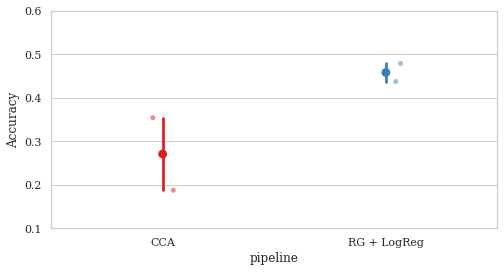

In [5]:
##############################################################################
# Plot Results
# ----------------
#
# Here we plot the results.

fig, ax = plt.subplots(facecolor='white', figsize=[8, 4])
sns.stripplot(data=results, y='score', x='pipeline', ax=ax, jitter=True,
              alpha=.5, zorder=1, palette="Set1")
sns.pointplot(data=results, y='score', x='pipeline', ax=ax,
              zorder=1, palette="Set1")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.1, 0.6)
plt.savefig('ssvep.png')
fig.show()